# Section 5 - Restricted Boltzmann Machine

### Implementation

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class RBM(object):
    def __init__(self, D, M, an_id):
        self.D = D
        self.M = M
        self.id = an_id
        self.build(D, M)

    def set_session(self, session):
        self.session = session

    def build(self, D, M):
        # params
        self.W = tf.Variable(tf.random_normal(shape=(D, M)) * np.sqrt(2.0 / M))
        # note: without limiting variance, you get numerical stability issues
        self.c = tf.Variable(np.zeros(M).astype(np.float32))
        self.b = tf.Variable(np.zeros(D).astype(np.float32))

        # data
        self.X_in = tf.placeholder(tf.float32, shape=(None, D))

        # conditional probabilities
        # NOTE: tf.contrib.distributions.Bernoulli API has changed in Tensorflow v1.2
        V = self.X_in
        p_h_given_v = tf.nn.sigmoid(tf.matmul(V, self.W) + self.c)
        self.p_h_given_v = p_h_given_v # save for later
        
        r = tf.random_uniform(shape=tf.shape(p_h_given_v))
        H = tf.to_float(r < p_h_given_v)

        p_v_given_h = tf.nn.sigmoid(tf.matmul(H, tf.transpose(self.W)) + self.b)
        
        r = tf.random_uniform(shape=tf.shape(p_v_given_h))
        X_sample = tf.to_float(r < p_v_given_h)


        # build the objective
        objective = tf.reduce_mean(self.free_energy(self.X_in)) - tf.reduce_mean(self.free_energy(X_sample))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(objective)
        

        # build the cost
        # we won't use this to optimize the model parameters
        # just to observe what happens during training
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.X_in,
                logits=logits,
            )
        )

    def fit(self, X, epochs = 1, batch_sz = 100, show_fig = False):
        N, D = X.shape
        n_batches = N // batch_sz

        costs = []
        
        for i in range(epochs):
            print("Epoch: ", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j * batch_sz : (j * batch_sz + batch_sz)]
                _, c = self.session.run((self.train_op, self.cost), 
                                        feed_dict = {self.X_in: batch})
                if j % 10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost: ", c)
                costs.append(c)
        if show_fig:
            plt.figure(figsize = (14, 14))
            plt.plot(costs)
            plt.show()

    def free_energy(self, V):
        b = tf.reshape(self.b, (self.D, 1))
        first_term = -tf.matmul(V, b)
        first_term = tf.reshape(first_term, (-1,))

        second_term = -tf.reduce_sum(
            # tf.log(1 + tf.exp(tf.matmul(V, self.W) + self.c)),
            tf.nn.softplus(tf.matmul(V, self.W) + self.c),
            axis=1
        )

        return first_term + second_term

    def forward_hidden(self, X):
        return tf.nn.sigmoid(tf.matmul(X, self.W) + self.c)

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.matmul(Z, tf.transpose(self.W)) + self.b

    def forward_output(self, X):
        return tf.nn.sigmoid(self.forward_logits(X))

    def transform(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.p_h_given_v, 
                                feed_dict = {self.X_in: X})

In [3]:
def getKaggleMNIST():
    train = pd.read_csv('./data/Section 2/train.csv').as_matrix().astype(np.float32)
    train = shuffle(train)

    Xtrain = train[:-1000, 1:] / 255
    Ytrain = train[:-1000, 0].astype(np.int32)

    Xtest  = train[-1000:, 1:] / 255
    Ytest  = train[-1000:, 0].astype(np.int32)
    return Xtrain, Ytrain, Xtest, Ytest

In [4]:
Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()

Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)
_, D = Xtrain.shape
K = len(set(Ytrain))

Epoch:  0
j / n_batches: 0 / 410 cost:  0.75114536
j / n_batches: 10 / 410 cost:  0.23542331
j / n_batches: 20 / 410 cost:  0.20533612
j / n_batches: 30 / 410 cost:  0.18643746
j / n_batches: 40 / 410 cost:  0.17147003
j / n_batches: 50 / 410 cost:  0.15969531
j / n_batches: 60 / 410 cost:  0.15469585
j / n_batches: 70 / 410 cost:  0.15457776
j / n_batches: 80 / 410 cost:  0.14040473
j / n_batches: 90 / 410 cost:  0.13518213
j / n_batches: 100 / 410 cost:  0.14109783
j / n_batches: 110 / 410 cost:  0.13563217
j / n_batches: 120 / 410 cost:  0.12635556
j / n_batches: 130 / 410 cost:  0.13126253
j / n_batches: 140 / 410 cost:  0.12190761
j / n_batches: 150 / 410 cost:  0.12472801
j / n_batches: 160 / 410 cost:  0.12154306
j / n_batches: 170 / 410 cost:  0.11368052
j / n_batches: 180 / 410 cost:  0.11742955
j / n_batches: 190 / 410 cost:  0.11605334
j / n_batches: 200 / 410 cost:  0.11216199
j / n_batches: 210 / 410 cost:  0.12190011
j / n_batches: 220 / 410 cost:  0.11172784
j / n_batche

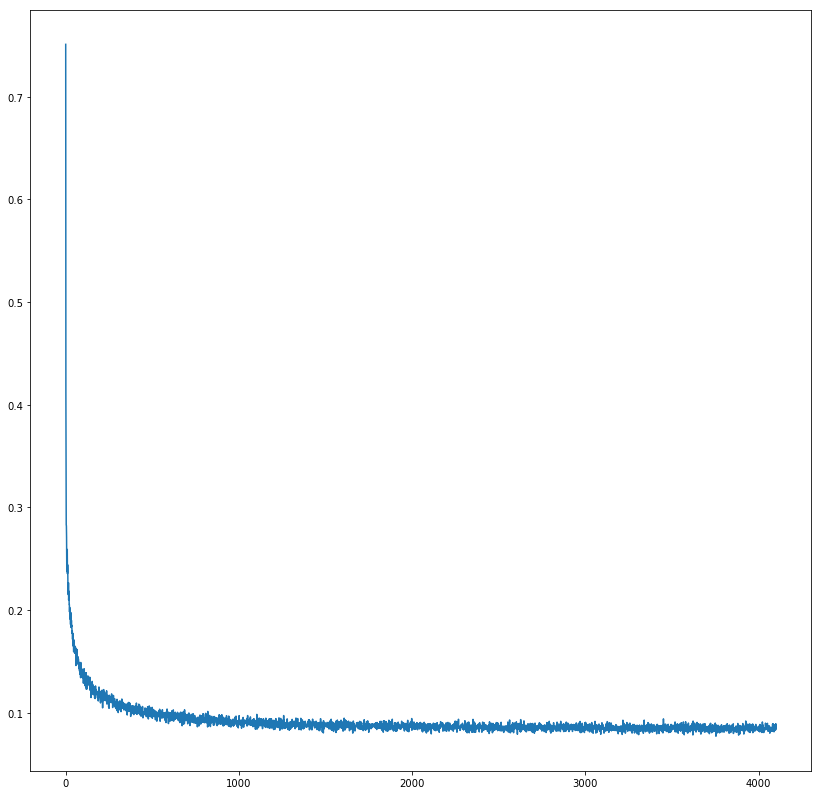

In [5]:
rbm = RBM(D, 300, 0)
init_op = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init_op)
    rbm.set_session(session)
    rbm.fit(Xtrain,  
            epochs = 10,
            show_fig = True)